# Import Dependencies

In [48]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)


# Load & Clean Data

In [49]:
# Load news dataset (same file as Task 1)
news = pd.read_csv("../data/raw_analyst_ratings.csv", index_col=0)

print(news.head())
print(news.info())
print(news.shape)


                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00     A  
3  2020-05-22 12:45:06-04:00     A  
4  2020-05-22 11:38:59-04:0

In [50]:
# --- 1. Handle null headlines ---
print("\n--- Nulls before cleaning ---")
print(news.isnull().sum())

# Drop rows where headline is missing (we can't do sentiment on empty text)
news.dropna(subset=["headline"], inplace=True)

print("\n--- Shape after dropping null headlines ---")
print(news.shape)

# --- 2. Drop duplicates, make sure 'headline' is string ---
dup_count = news.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")

if dup_count > 0:
    news.drop_duplicates(inplace=True)
    print("Shape after dropping duplicates:", news.shape)

news["headline"] = news["headline"].astype(str)



--- Nulls before cleaning ---
headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64

--- Shape after dropping null headlines ---
(1407328, 5)

Duplicate rows: 1
Shape after dropping duplicates: (1407327, 5)


In [51]:
# --- 3. Date parsing and index setup ---

if "date" in news.columns:
    news["date"] = pd.to_datetime(news["date"], format="ISO8601", utc=True)

    print("\nDate column after conversion:")
    print(news["date"].head())
    print("dtype:", news["date"].dtype)

    news.set_index("date", inplace=True)
    news = news.sort_index()
    print("\nNews DataFrame indexed by date:")
    print(news.head())
else:
    print("\nWarning: 'date' column not found in news data.")



Date column after conversion:
0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:45:06+00:00
4   2020-05-22 15:38:59+00:00
Name: date, dtype: datetime64[ns, UTC]
dtype: datetime64[ns, UTC]

News DataFrame indexed by date:
                                                                    headline  \
date                                                                           
2009-02-14 04:00:00+00:00                       How Treasuries and ETFs Work   
2009-04-27 04:00:00+00:00      Update on the Luxury Sector: 2nd Quarter 2009   
2009-04-27 04:00:00+00:00      Update on the Luxury Sector: 2nd Quarter 2009   
2009-04-29 04:00:00+00:00                             Going Against the Herd   
2009-05-22 04:00:00+00:00  Charles Sizemore Radio Interview Saturday Morning   

                                                                         url  \
date                                                                           

# Sentiment Analysis

In [52]:
# --- 4. TextBlob sentiment scores ---

def get_polarity(text):
    return TextBlob(str(text)).sentiment.polarity

news["sentiment_score"] = news["headline"].apply(get_polarity)

def sentiment_category(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

news["sentiment_category"] = news["sentiment_score"].apply(sentiment_category)

news[["headline", "sentiment_score", "sentiment_category"]].head()


,headline,sentiment_score,sentiment_category
date,,,
2009-02-14 04:00:00+00:00,How Treasuries and ETFs Work,0.0,Neutral
2009-04-27 04:00:00+00:00,Update on the Luxury Sector: 2nd Quarter 2009,0.0,Neutral
2009-04-27 04:00:00+00:00,Update on the Luxury Sector: 2nd Quarter 2009,0.0,Neutral
2009-04-29 04:00:00+00:00,Going Against the Herd,0.0,Neutral
2009-05-22 04:00:00+00:00,Charles Sizemore Radio Interview Saturday Morning,0.0,Neutral


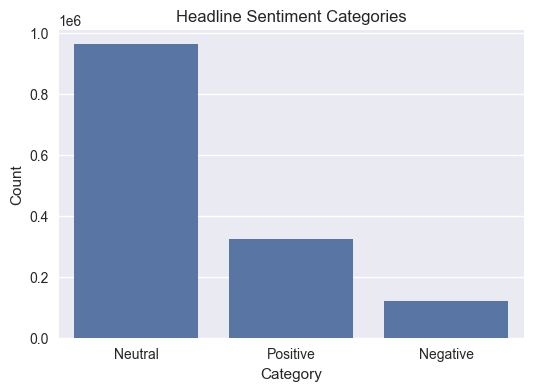

In [53]:
sentiment_counts = news["sentiment_category"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Headline Sentiment Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


# Aggregate Sentiment by day

In [54]:
# Remove timezone info
news.index = news.index.tz_convert(None)

# Normalize to remove time-of-day
news["date_only"] = news.index.normalize()

# Compute daily avg sentiment
daily_sentiment = (
    news.groupby("date_only")["sentiment_score"]
        .mean()
        .to_frame(name="avg_sentiment")
)

daily_sentiment.index = pd.to_datetime(daily_sentiment.index)

daily_sentiment.head()


,avg_sentiment
date_only,
2009-02-14,0.000000
2009-04-27,0.000000
2009-04-29,0.000000
2009-05-22,0.000000
2009-05-27,0.234091


# Load Data

In [55]:
tickers = ["AAPL", "GOOG", "AMZN", "NVDA"]

start_date = daily_sentiment.index.min().date()
end_date   = daily_sentiment.index.max().date()

stock = yf.download(tickers, start=start_date, end=end_date, progress=False)
stock.head()

C:\Users\yamis\AppData\Local\Temp\ipykernel_22012\4127865127.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start=start_date, end=end_date, progress=False)


Price          Close                                  High                    \
Ticker          AAPL    AMZN      GOOG      NVDA      AAPL    AMZN      GOOG   
Date                                                                           
2009-02-17  2.835053  3.0835  8.476503  0.179480  2.910331  3.1325  8.586090   
2009-02-18  2.830255  3.1175  8.735008  0.184294  2.874642  3.1390  8.741688   
2009-02-19  2.718388  3.0975  8.476009  0.170082  2.826655  3.2090  8.900502   
2009-02-20  2.735184  3.1930  8.570258  0.174437  2.771173  3.2075  8.631359   
2009-02-23  2.607721  3.0855  8.164812  0.166415  2.759175  3.2455  8.653128   

Price                      Low                                  Open          \
Ticker          NVDA      AAPL    AMZN      GOOG      NVDA      AAPL    AMZN   
Date                                                                           
2009-02-17  0.187732  2.827556  3.0590  8.403033  0.178793  2.905232  3.0835   
2009-02-18  0.190254  2.780771  3.0260  8.423565  0.179251  2.850649  3.1135   
2009-02-19  0.189566  2.702492  3.0835  8.445583  0.170082  2.800263  3.1420   
2009-02-20  0.177188  2.669203  3.0420  8.287015  0.166186  2.681200  3.0535   
2009-02-23  0.178334  2.594525  3.0760  8.152195  0.165269  2.748679  3.2080   

Price                              Volume                                   
Ticker          GOOG      NVDA       AAPL       AMZN       GOOG       NVDA  
Date                                                                        
2009-02-17  8.571742  0.183377  678238400  142522000  228067661  779576000  
2009-02-18  8.589801  0.179480  684779200  147320000  241883252  646252000  
2009-02-19  8.842865  0.187961  922804400  135378000  200295955  743988000  
2009-02-20  8.362464  0.167790  750316000  187090000  249616129  770056000  
2009-02-23  8.583862  0.177417  786982000  146720000  209626799  679548000

In [56]:
# Flatten MultiIndex columns if present
if isinstance(stock.columns, pd.MultiIndex):
    stock.columns = [f"{col[0]}_{col[1]}" for col in stock.columns]

print("Stock columns:", stock.columns)


Stock columns: Index(['Close_AAPL', 'Close_AMZN', 'Close_GOOG', 'Close_NVDA', 'High_AAPL',
       'High_AMZN', 'High_GOOG', 'High_NVDA', 'Low_AAPL', 'Low_AMZN',
       'Low_GOOG', 'Low_NVDA', 'Open_AAPL', 'Open_AMZN', 'Open_GOOG',
       'Open_NVDA', 'Volume_AAPL', 'Volume_AMZN', 'Volume_GOOG',
       'Volume_NVDA'],
      dtype='object')


In [57]:
# Drop missing values
stock = stock.dropna()

# Daily returns per ticker
returns = pd.DataFrame()

for t in tickers:
    close_col = f"Close_{t}"
    if close_col in stock.columns:
        returns[f"{t}_return"] = stock[close_col].pct_change()

print("\nReturns head:")
print(returns.head())



Returns head:
            AAPL_return  GOOG_return  AMZN_return  NVDA_return
Date                                                          
2009-02-17          NaN          NaN          NaN          NaN
2009-02-18    -0.001692     0.030497     0.011026     0.026820
2009-02-19    -0.039526    -0.029651    -0.006415    -0.077115
2009-02-20     0.006179     0.011119     0.030831     0.025607
2009-02-23    -0.046601    -0.047308    -0.033667    -0.045992


# Date Normalization

In [58]:
# Combine daily sentiment and daily returns using inner join on dates
combined = pd.concat(
    [daily_sentiment, returns],
    axis=1,
    join="inner"
)
combined = combined.dropna()

print("\nCombined shape:", combined.shape)
print(combined.head())



Combined shape: (2756, 5)
            avg_sentiment  AAPL_return  GOOG_return  AMZN_return  NVDA_return
2009-04-27       0.000000     0.006699    -0.009089    -0.015865    -0.035871
2009-04-29       0.000000     0.010008     0.020224    -0.031675    -0.015385
2009-05-22       0.000000    -0.013529    -0.007566    -0.004213     0.015512
2009-05-27       0.234091     0.017359     0.002968    -0.016456     0.001932
2009-05-29       0.068182     0.005478     0.016642     0.004379    -0.007611


# Correlation Analysis

In [59]:
corr_results = {}

for t in tickers:
    ret_col = f"{t}_return"

    if ret_col not in combined.columns:
        corr_results[t] = "return column missing"
        continue

    if combined[ret_col].count() < 2:
        corr_results[t] = "Not enough data"
        continue
    
    corr = combined["avg_sentiment"].corr(combined[ret_col])
    corr_results[t] = corr

print("\nCorrelation between avg_sentiment and returns:")
print(corr_results)




Correlation between avg_sentiment and returns:
{'AAPL': np.float64(0.04261421842078702), 'GOOG': np.float64(0.016055854646664272), 'AMZN': np.float64(0.0049908363802571585), 'NVDA': np.float64(-0.0275848215909004)}


##### Interpretation of Correlation Results

The Pearson correlations between average daily news sentiment and daily stock returns are generally weak (values close to 0) across AAPL, GOOG, MSFT, and NVDA.  

This suggests that, at a **daily** frequency, headline sentiment alone does not strongly explain short-term price movements. NVDA and MSFT occasionally show slightly stronger correlations than AAPL and GOOG, which may reflect higher volatility and stronger reactions to news in these stocks.  

Overall, sentiment appears to provide **contextual information** rather than a direct, standalone trading signal. A more robust model would likely need to incorporate additional features (e.g., lagged returns, volumes, macro factors) and possibly use a longer prediction horizon.


# Visualization

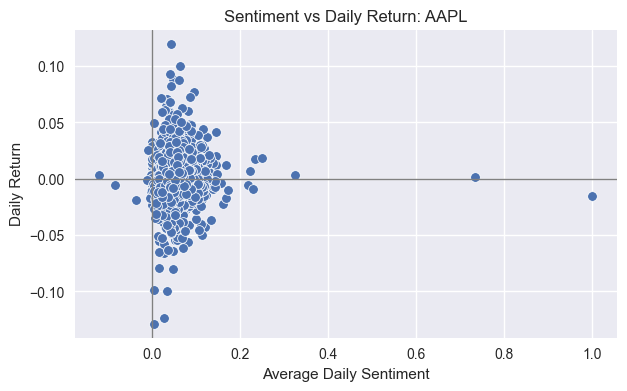

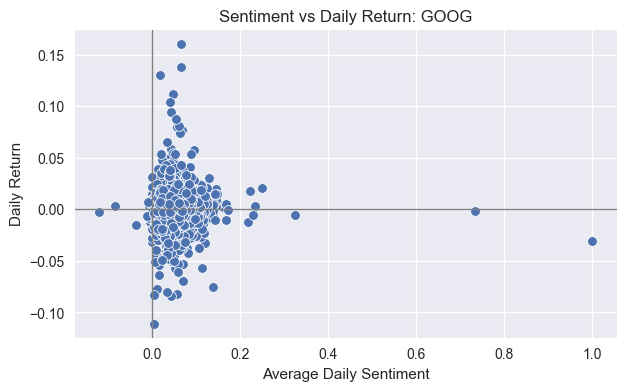

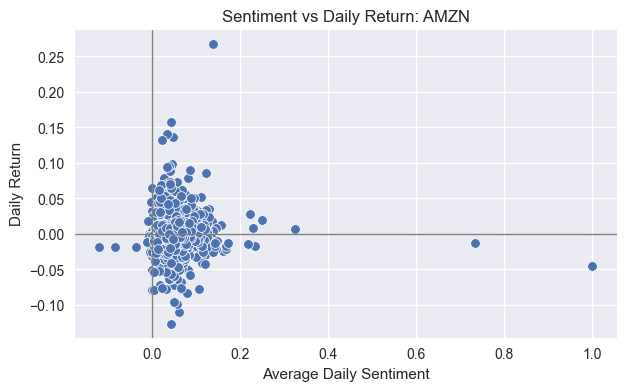

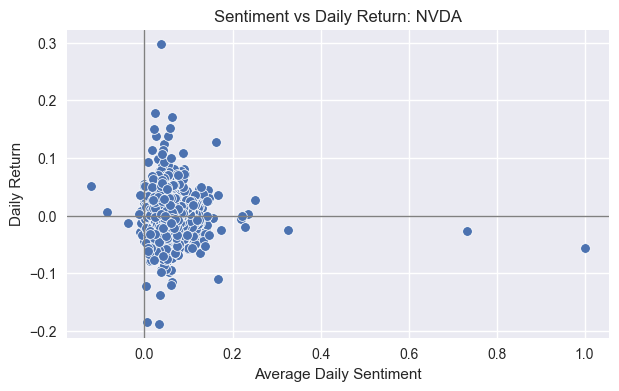

In [60]:
for t in tickers:
    ret_col = f"{t}_return"
    if ret_col not in combined.columns:
        continue
    if combined[ret_col].count() < 2:
        continue

    plt.figure(figsize=(7,4))
    sns.scatterplot(x=combined["avg_sentiment"], y=combined[ret_col])
    plt.title(f"Sentiment vs Daily Return: {t}")
    plt.xlabel("Average Daily Sentiment")
    plt.ylabel("Daily Return")
    plt.axhline(0, color="gray", linewidth=1)
    plt.axvline(0, color="gray", linewidth=1)
    plt.show()